![](../img/330-banner.png)

Lecture 19: Time Series
-------------------

UBC 2022-23 W2

Instructor: Amir Abdi

Office Hours: Mondays 5-6 PM

Anonymous Feedback: https://forms.gle/t21FhAVG8aY2mFs56

## Legends

    
| <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/This_is_the_photo_of_Arthur_Samuel.jpg" width="100"> | <img src="https://www.ml.cmu.edu/images/news/mitchell-2017-wef-900-min.jpg" width="100">  | <img src="https://upload.wikimedia.org/wikipedia/commons/4/49/John_McCarthy_Stanford.jpg" width="100"> | <img src="https://datascience.columbia.edu/wp-content/uploads/2020/08/Vapnik_web.png" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/a/a1/Alan_Turing_Aged_16.jpg" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/Yoshua_Bengio_2019_cropped.jpg" width="100"> |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | 
| Arthur Samuel       | Tom Mitchell       |John McCarthy|  Vladimir N. Vapnik | Alan Turing | Yoshua Bengio |
| (1901-1990)    | 1951 - Now       |  1927 – 2011 | 1936 - Now | 1912 – 1954 | 1964-Now |
| First computer learning program | 1997 ML Texbook, CMU Prof | Co-coined term AI, Lisp,<br> Time-sharing, Garbage collection | SVM | Turing Test, Turning Machine | Turing Award<br> Father of Deep Learning


| <img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Lloyd_Shapley_2_2012.jpg" width="100"> | <img src="https://stat.columbia.edu/wp-content/uploads/connections-images/david-blei/Blei-David-1.jpg" width="100"> | <img src="http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcTOOIquVIk-AUTan-9Rf0sG-Gl9P7ngVNdC2oLFUFc-4gkiB1wydkt2s36vjC8c7C8Xhtj6cxHNHEPR9xw" width="100"> | <img src="https://yale2020.yale.edu/sites/default/files/jordan_front_facing_bettman_1562_1_0_0_0.jpg" width="100"> |
|   :-----------:  | :-----------:  | :-----------:  | :-----------:  | 
| Lloyd Shapley | David Blei | Andrew Ng | Michael Jordan |
| 1923-2016  | ? - Now | 1976 - Now | 1956 - Now |
| Shapley values (SHAP) | LDA |  LDA, Coursera Founder, Director of SAIL | LDA |

## Yann LeCun

<img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Yann_LeCun_-_2018_%28cropped%29.jpg" width="200">

- He is the father of **Convolutional neural networks (CNN)**
- Received the 2018 **Turing Award**, together with Yoshua Bengio and Geoffrey Hinton
- Director of Meta AI 

## Imports, announcements, LO

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

### Announcements
- HW8 (**the very last homework!**) is out, due April 12, 11:59pm

### Learning objectives

- Recognize when it is appropriate to use time series. 
- Explain the **pitfalls of train/test splitting** with time series data.
- Appropriately split time series data, both train/test split and cross-validation.
- Perform time series feature engineering:
  - Encode time as various features in a tabular dataset 
  - Create **lag-based (lagged)** features
- Explain how can you forecast multiple time steps into the future.
- Explain the challenges of time series data with **unequally spaced time points**.
- At a high level, explain the concept of **trend**.

## Motivation

- **Time series** is a collection of data points indexed in time order. 
- Time series is everywhere:
    - Physical sciences (e.g., weather forecasting)  
    - Economics, finance (e.g., stocks, market trends)
    - Engineering (e.g., energy consumption)
    - Social sciences 
    - Sports analytics

Let's start with a simple example from [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/). 

In New York city there is a network of bike rental stations with a subscription system. The stations are all around the city. The anonymized data is available [here](https://ride.citibikenyc.com/system-data).

We will focus on the task is predicting how many people will rent a bicycle from **a particular station** for a given time and day. We might be interested in knowing this so that we know whether there will be any bikes left at the station for a particular day and time.  

In [2]:
import mglearn

citibike = mglearn.datasets.load_citibike()
citibike.head(17)

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/mglearn/datasets.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_resampled = data_starttime.resample("3h").sum().fillna(0)


starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
2015-08-01 15:00:00    27
2015-08-01 18:00:00    12
2015-08-01 21:00:00     4
2015-08-02 00:00:00     3
2015-08-02 03:00:00     4
2015-08-02 06:00:00     6
2015-08-02 09:00:00    30
2015-08-02 12:00:00    46
2015-08-02 15:00:00    27
2015-08-02 18:00:00    28
2015-08-02 21:00:00     6
2015-08-03 00:00:00     3
Freq: 3H, Name: one, dtype: int64

- The only feature we have is the date time feature. 
    - Example: 2015-08-01 00:00:00
- The target is the number of rentals in the next 3 hours. 
    - Example: 3 rentals between 2015-08-01 00:00:00 and 2015-08-01 03:00:00

Let's check the time duration of our data. 

In [3]:
citibike.index.min()

Timestamp('2015-08-01 00:00:00', freq='3H')

In [4]:
citibike.index.max()

Timestamp('2015-08-31 21:00:00', freq='3H')

**We have data for August 2015.**

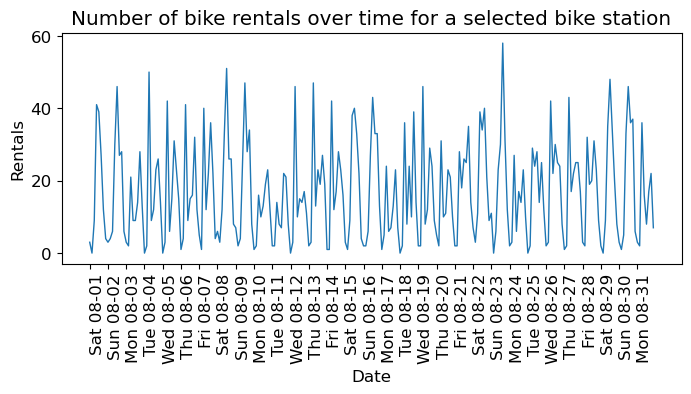

In [5]:
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq="D")
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");
plt.title("Number of bike rentals over time for a selected bike station");

- We see the day and night pattern
- We see the weekend and weekday pattern 

- Questions you might want to answer: 
  - **How many people are likely to rent a bike at this station in the next three hours given everything we know about rentals in the past?**
- We want to learn from the past and predict the future. 

Can we use our usual machine learning methodology for this problem? 

### Train/test split for temporal data

- What will happen if we split this data the usual way?

In [7]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [8]:
test_df.head()

starttime
2015-08-26 12:00:00    30
2015-08-12 09:00:00    10
2015-08-19 03:00:00     2
2015-08-07 12:00:00    22
2015-08-03 09:00:00     9
Name: one, dtype: int64

In [9]:
train_df.index.max()

Timestamp('2015-08-31 21:00:00')

In [10]:
test_df.index.min()

Timestamp('2015-08-01 12:00:00')

- So, we are training on data that came after our test data!
- Problems:
  - If we want to forecast, **we aren't allowed to know what happened in the future**!
  - We don't want to **break the pattern** in our historical data (i.e., we want our historical data to be accurate)

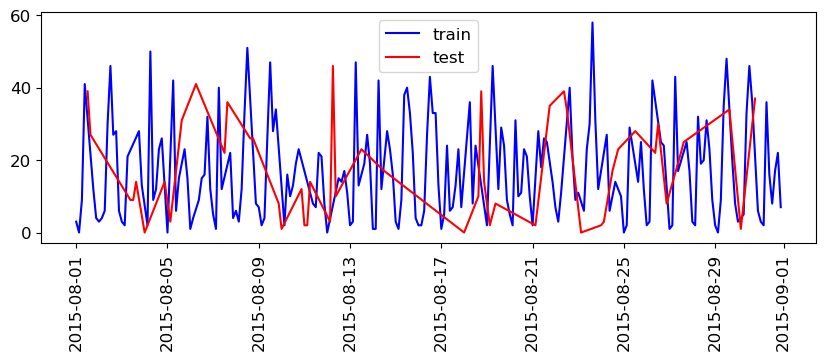

In [11]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

**So, the above is INCORRECT!**
- Test data is **temporally overlapping** with Train data
- Events in train data are **missing some samples** (they have been excluded and moved to Test set)

### The correct data splitting approach for Time-Series

We'll split the data as follows:

- We have total 248 data points. 
- We'll use the fist 184 data points corresponding to the first 23 days as training data - And the remaining 64 data points corresponding to the remaining 8 days as test data. 

In [12]:
citibike.shape

(248,)

In [13]:
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

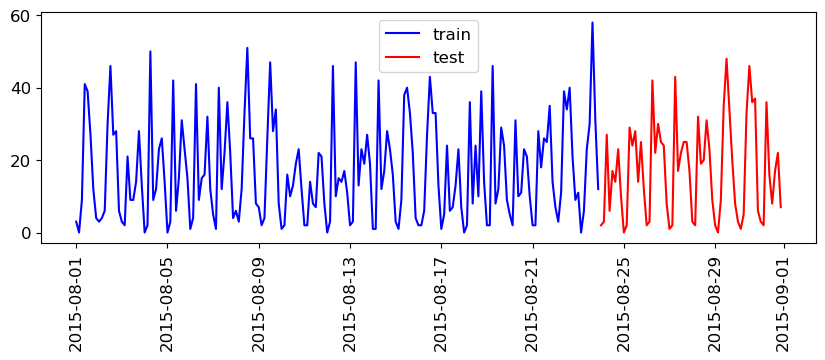

In [14]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

- This split is looking reasonable now. 

<br><br>

### Training models 

- We need to encode the **date time feature feature** which is our **only feature**!
- A common way that dates are stored on computers is using **POSIX time**, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time). 
- Let's start with encoding this feature as a single integer representing this POSIX time. 

In [15]:
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64

In [16]:
X = (
    citibike.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
)  # convert to POSIX time by dividing by 10**9 (nano seconds -> seconds)
y = citibike.values

In [17]:
X[:3]

array([[1438387200],
       [1438398000],
       [1438408800]])

Number of seconds since `January 1970 00:00:00 `

Create Train and Test datasets:

In [18]:
y_train = train_df.values
y_test = test_df.values
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9

In [19]:
X_train[:10]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400]])

In [20]:
y_train[:10]

array([ 3,  0,  9, 41, 39, 27, 12,  4,  3,  4])

- Our prediction task is a regression task. 

- Let's try random forest regression with just this feature. 
- We'll be trying out many different features. So we'll be using the function below which
    - Splits the data 
    - Trains the given regressor model on the training data
    - Shows train and test scores
    - Plots the predictions on the train and test data

In [21]:
# Code credit: Adapted from 
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

# regressor: ML model to use for regression

def eval_on_features(features, target, regressor, n_train = 184, sales_data=False, ylabel='Rentals'):
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    # Fit on train data     
    regressor.fit(X_train, y_train)
    
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    if not sales_data: 
        plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
        
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")

    plt.plot(
        range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test"
    )
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

Let's try random forest regressor with our posix time feature. 

Train-set R^2: 0.85
Test-set R^2: -0.04


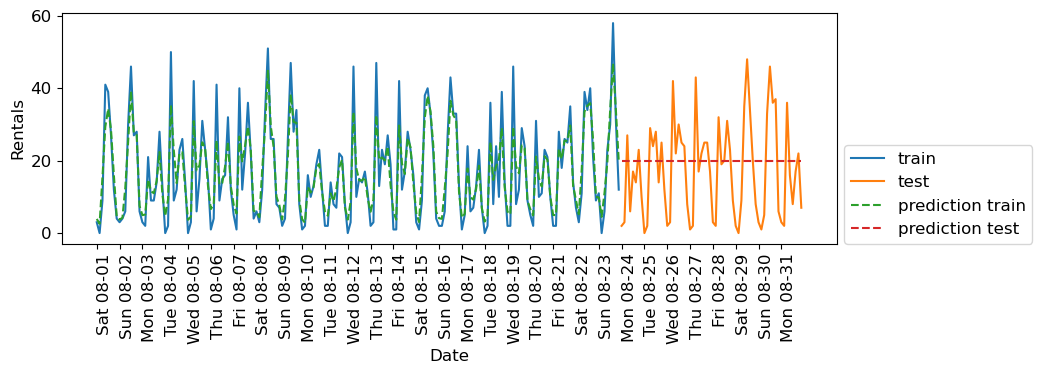

In [22]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

- The predictions on the training score is pretty good 
- But for the test data, a constant line is predicted ...
- What's going on? 

<br><br>
**What we did above is a stupid approach, no one does this!**   
I'm just trying to show you why **NOT** to do this :)
<br><br><br><br>

- The model is based on only one feature: POSIX time feature. 
- And the value of the POSIX time feature is outside the range of the feature values in the training set. 
- Tree-based models **cannot _extrapolate_ to feature ranges outside the training data**. 
- The model predicted the target value of the closest point in the training set. 

Let's look at the data.  
In this **stupid** approach, each sample looks like the following:

In [23]:
X[0]

array([1438387200])

Which represents a point in time (a time span of 3 hours to be exact).  
With a corresponding target:

In [24]:
y[0]

3

We **CANNOT** expect the model to make predictions for a **point in future** which it has never seen.  

Analogy: If your data has a feature called Color, and your training set has only BLUE and RED colors, you can't expect your model to well-behave for a sample with color YELLOW.

### Feature engineering for date/time columns

Note that our feature (which is also the index of the DataFrame) is of this special type: [DateTimeIndex](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html). We can extract all kinds of interesting information from it.   

In [25]:
citibike.index

DatetimeIndex(['2015-08-01 00:00:00', '2015-08-01 03:00:00',
               '2015-08-01 06:00:00', '2015-08-01 09:00:00',
               '2015-08-01 12:00:00', '2015-08-01 15:00:00',
               '2015-08-01 18:00:00', '2015-08-01 21:00:00',
               '2015-08-02 00:00:00', '2015-08-02 03:00:00',
               ...
               '2015-08-30 18:00:00', '2015-08-30 21:00:00',
               '2015-08-31 00:00:00', '2015-08-31 03:00:00',
               '2015-08-31 06:00:00', '2015-08-31 09:00:00',
               '2015-08-31 12:00:00', '2015-08-31 15:00:00',
               '2015-08-31 18:00:00', '2015-08-31 21:00:00'],
              dtype='datetime64[ns]', name='starttime', length=248, freq='3H')

In [26]:
citibike.index.month_name()

Index(['August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August',
       ...
       'August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August'],
      dtype='object', name='starttime', length=248)

In [27]:
citibike.index.dayofweek

Int64Index([5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
            ...
            6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name='starttime', length=248)

In [28]:
citibike.index.day_name()

Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Sunday', 'Sunday',
       ...
       'Sunday', 'Sunday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object', name='starttime', length=248)

In [29]:
citibike.index.hour

Int64Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
            ...
            18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
           dtype='int64', name='starttime', length=248)

- We noted before that the time of the day and day of the week seem quite important. 
- Let's add these two features. 

Let's first add the **time of the day**. 

In [30]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour[:10]

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12],
       [15],
       [18],
       [21],
       [ 0],
       [ 3]])

Train-set R^2: 0.50
Test-set R^2: 0.60


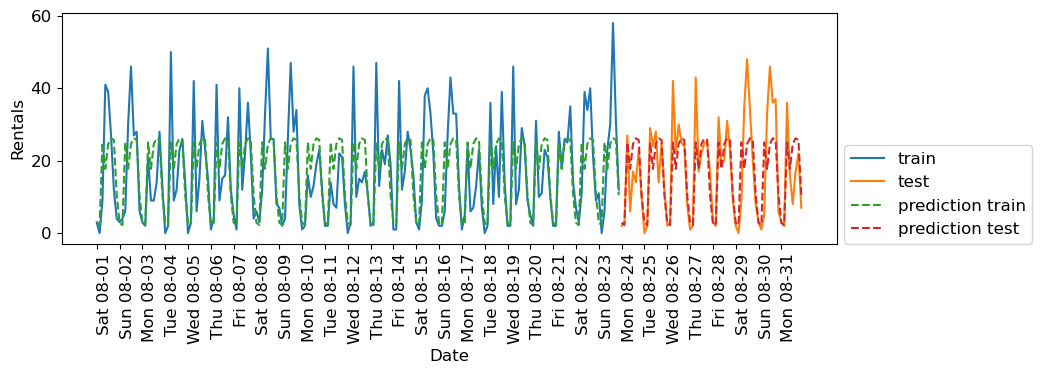

In [31]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor)

The scores are better when we add time of the day feature. 

Now let's add **day of the week** along with time of the day. 

Train-set R^2: 0.89
Test-set R^2: 0.84


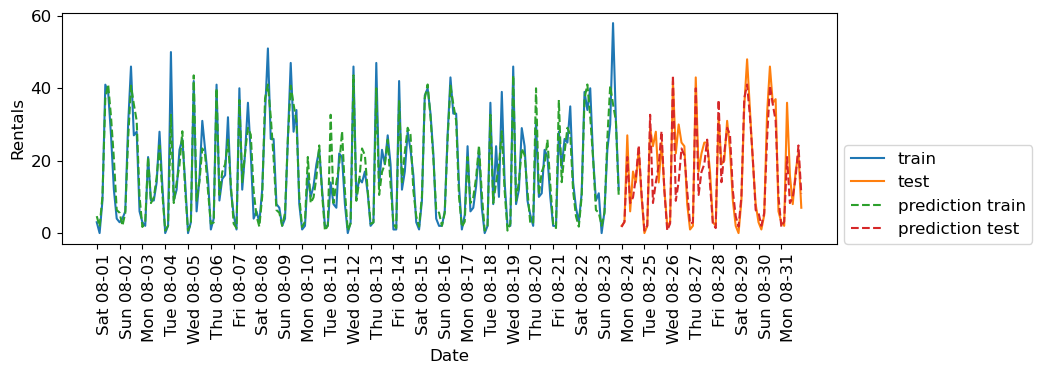

In [32]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
X_hour_week = np.hstack(
    [
        citibike.index.dayofweek.values.reshape(-1, 1),
        citibike.index.hour.values.reshape(-1, 1),
    ]
)
eval_on_features(X_hour_week, y, regressor)

In [33]:
X_hour_week[:10]

array([[ 5,  0],
       [ 5,  3],
       [ 5,  6],
       [ 5,  9],
       [ 5, 12],
       [ 5, 15],
       [ 5, 18],
       [ 5, 21],
       [ 6,  0],
       [ 6,  3]])

The results are much better. The time of the day and day of the week features are clearly helping. 

- Do we need a complex model such as a random forest? 
- Let's try `Ridge` with these features.

Train-set R^2: 0.16
Test-set R^2: 0.13


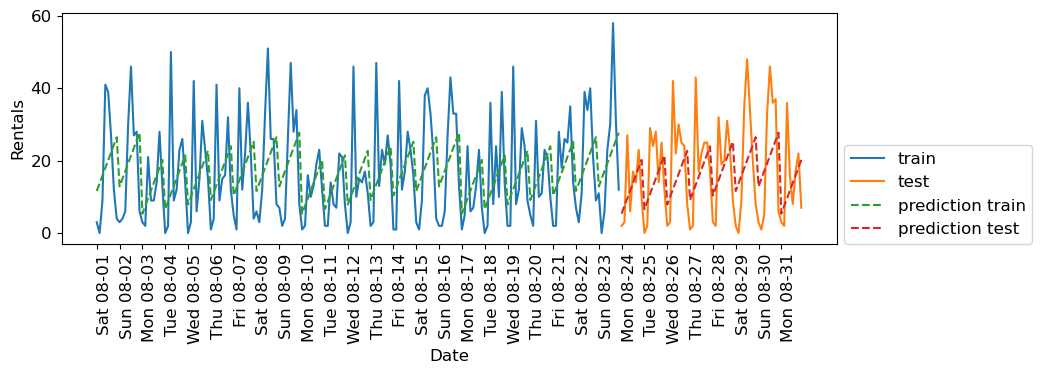

In [34]:
from sklearn.linear_model import Ridge

lr = Ridge()
eval_on_features(X_hour_week, y, lr)

- Ridge is performing poorly on the training as well as test data.
- It's not able to capture the periodic pattern.
- The reason is that we have **encoded time of day with integers**. 
  - **A linear function** can only learn a **linear function** of the time of day. 
- What if we encode this feature as a categorical variable? 

In [35]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [36]:
X_hour_week_onehot
X_hour_week_onehot.shape

(248, 15)

In [37]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

In [38]:
pd.DataFrame(X_hour_week_onehot, columns=features)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
X_hour_week_onehot[:10]

array([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]])

Train-set R^2: 0.53
Test-set R^2: 0.62


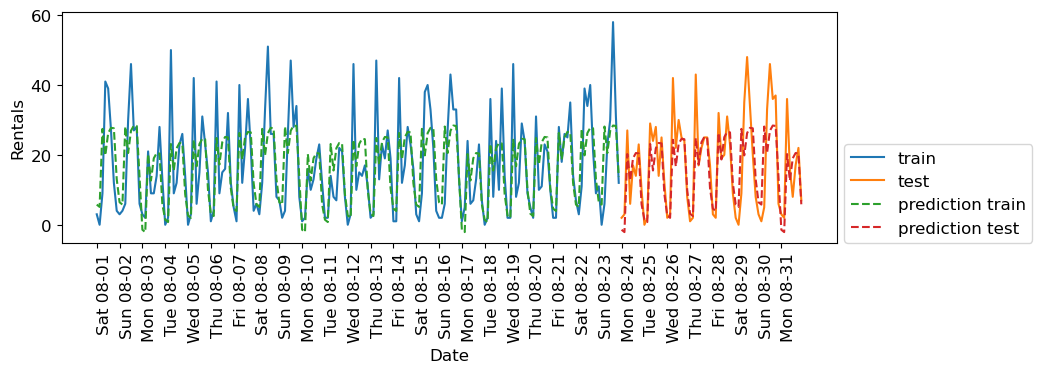

In [40]:
eval_on_features(X_hour_week_onehot, y, Ridge())

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

Generate a new feature matrix consisting of all polynomial combinations of the features with **degree less than or equal to the specified degree**. 

Example: 
- input sample with 2 features = [a, b] --> degree-2 polynomial features = [1, a, b, a^2, ab, b^2]
- input sample with 2 features = [a, b] --> degree-3 polynomial features = [1, a, b, a^2, ab, b^2, a^3, b^3, a^2b, ab^2]

With `PolynomialFeatures`, we can create feature which are composed of two features such as: **On Monday at 9 AM** 

We can do it using `sklearn`'s `PolynomialFeatures` transformer. 

In [41]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False, degree=2
)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

In [42]:
X_hour_week_onehot.shape

(248, 15)

In [43]:
X_hour_week_onehot_poly.shape

(248, 120)

In [44]:
X_hour_week_onehot_poly[:2]

array([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

Train-set R^2: 0.87
Test-set R^2: 0.85


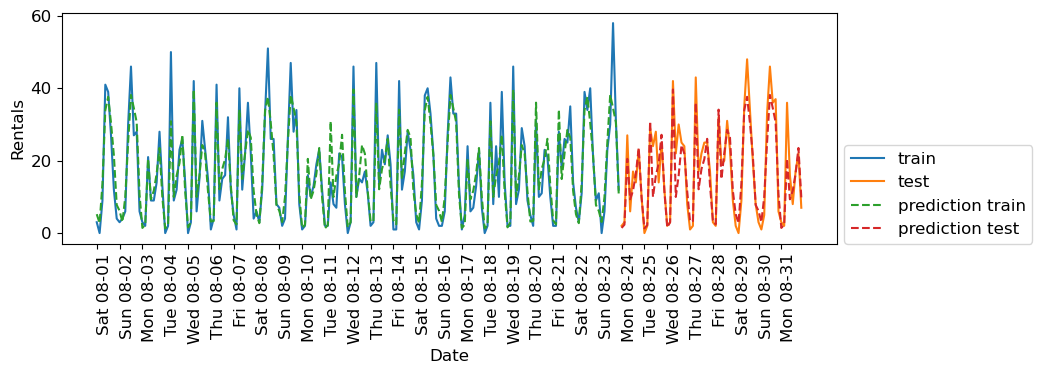

In [45]:
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [46]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour
features

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

Let's examine the coefficients learned by `Ridge`. 

In [47]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [48]:
sum(lr.coef_ == 0)

49

Filtering out features with **zero** coefficients (**there are 49 useless features**)

In [49]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
Sat 09:00,15.196739
Wed 06:00,15.005809
Sat 12:00,13.437684
Sun 12:00,13.362009
Thu 06:00,10.907595
...,...
Sat 21:00,-6.085150
00:00,-11.693898
03:00,-12.111220
Sat 06:00,-13.757591


- The coefficients make sense!
- If it's Saturday 09:00 or Wednesday 06:00, the model is likely to predict bigger number for rentals. 
- If it's Midnight or 03:00 or Sunday 06:00, the model is likely to predict smaller number for rentals. 

<br><br><br>
**reminder note:** RandomForest Regressor achieved the same results using the following features because it was capable of learning non-linear relationships between features and target, as well as interactions between features:

In [50]:
X_hour_week[:10]

array([[ 5,  0],
       [ 5,  3],
       [ 5,  6],
       [ 5,  9],
       [ 5, 12],
       [ 5, 15],
       [ 5, 18],
       [ 5, 21],
       [ 6,  0],
       [ 6,  3]])

<br><br>

## Lag-based features

- So far we engineered some features and managed to get reasonable results. 
- In time series data there is temporal dependence; **observations close in time (temporal correlation) tend to be correlated**. 
- Currently we're using current time to predict the number of bike rentals at that time. 
- But, what if **the number of bike rentals is also related to bike rentals three hours ago or 6 hours ago** and so on? 
  - Such features are called _lagged_ features.  
  
_Note: In time series analysis, you would look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here._ 

Let's extract lag features. We can "lag" (or "shift") a time series in Pandas with the `.shift()` method.

<img src="https://robjhyndman.com/files/cv1-1.png">

In [51]:
rentals_df = pd.DataFrame(citibike)
rentals_df = rentals_df.rename(columns={"one":"n_rentals"})
rentals_df

,n_rentals
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39
...,...
2015-08-31 09:00:00,16
2015-08-31 12:00:00,8
2015-08-31 15:00:00,17


In [53]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [54]:
rentals_lag5 = create_lag_df(rentals_df, 5, ['n_rentals'] )

In [55]:
rentals_lag5.head(10)

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
2015-08-01 15:00:00,27,39.0,41.0,9.0,0.0,3.0
2015-08-01 18:00:00,12,27.0,39.0,41.0,9.0,0.0
2015-08-01 21:00:00,4,12.0,27.0,39.0,41.0,9.0
2015-08-02 00:00:00,3,4.0,12.0,27.0,39.0,41.0


In [56]:
X_lag_features = rentals_lag5.drop(columns = ['n_rentals']).to_numpy()

In [57]:
X_lag_features[:10]

array([[nan, nan, nan, nan, nan],
       [ 3., nan, nan, nan, nan],
       [ 0.,  3., nan, nan, nan],
       [ 9.,  0.,  3., nan, nan],
       [41.,  9.,  0.,  3., nan],
       [39., 41.,  9.,  0.,  3.],
       [27., 39., 41.,  9.,  0.],
       [12., 27., 39., 41.,  9.],
       [ 4., 12., 27., 39., 41.],
       [ 3.,  4., 12., 27., 39.]])

- Note the NaN pattern. 
- We can **drop the first 5 rows** (or apply imputation)
  - **If you have enough data (if your sequences are long enough), just drop them**
- Let's try these features with Ridge model. 

We didn't keep any notion of **time**; we are only keeping the **past 5 historical rental events**

In [58]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)

Let's try `RandomForestRegressor` model

Train-set R^2: 0.94
Test-set R^2: 0.70


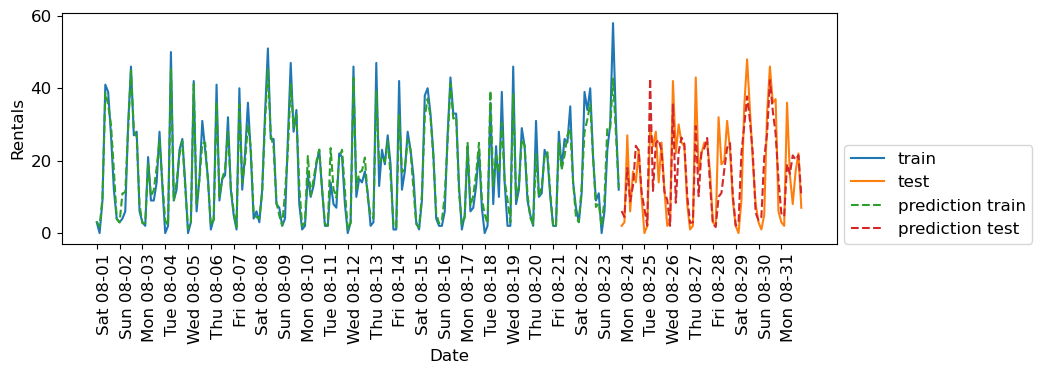

In [59]:
rf = RandomForestRegressor(random_state=1234)
eval_on_features(X_lag_features_imp, y, rf)

The results are not as good as the results with our preciously engineered features. 

How about combining lag-based features and the previously extracted features? 

In [60]:
X_hour_week[10:20]

array([[ 6,  6],
       [ 6,  9],
       [ 6, 12],
       [ 6, 15],
       [ 6, 18],
       [ 6, 21],
       [ 0,  0],
       [ 0,  3],
       [ 0,  6],
       [ 0,  9]])

In [61]:
X_hour_week_lag = np.hstack([X_hour_week, X_lag_features_imp])
X_hour_week_lag[10:20]

array([[ 6.,  6.,  4.,  3.,  4., 12., 27.],
       [ 6.,  9.,  6.,  4.,  3.,  4., 12.],
       [ 6., 12., 30.,  6.,  4.,  3.,  4.],
       [ 6., 15., 46., 30.,  6.,  4.,  3.],
       [ 6., 18., 27., 46., 30.,  6.,  4.],
       [ 6., 21., 28., 27., 46., 30.,  6.],
       [ 0.,  0.,  6., 28., 27., 46., 30.],
       [ 0.,  3.,  3.,  6., 28., 27., 46.],
       [ 0.,  6.,  2.,  3.,  6., 28., 27.],
       [ 0.,  9., 21.,  2.,  3.,  6., 28.]])

Train-set R^2: 0.96
Test-set R^2: 0.79


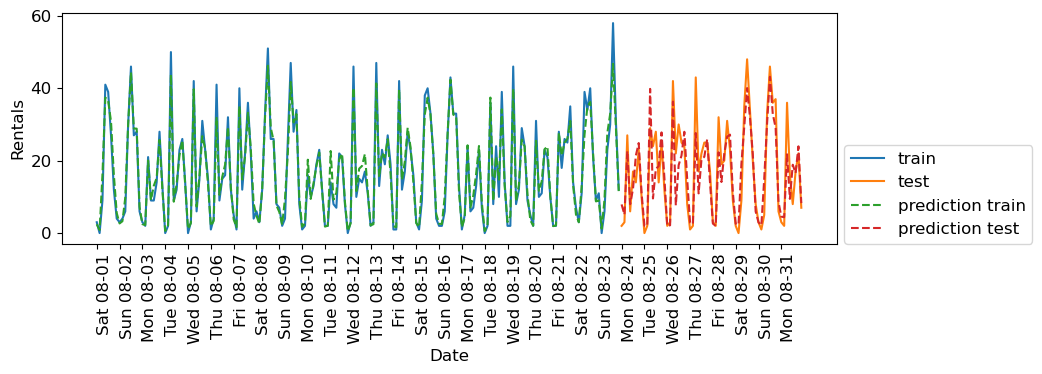

In [62]:
rf = RandomForestRegressor(random_state=123)
eval_on_features(X_hour_week_lag, y, rf)

Comparing this with the results we previously got from `RandomForestRegressor` on `X_hour` features:
```
Train-set R^2: 0.89
Test-set R^2: 0.84
``

We see improvement on Train, but performing worse on Test set.  
We have increased the variance, but, reduced its bias.


### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- If you carry out regular cross-validation, you'll be predicting the past given future which is not a realistic scenario for the deployment data. 

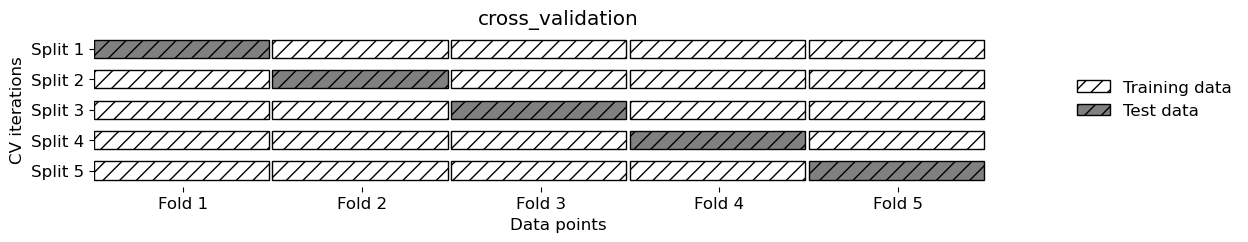

In [63]:
mglearn.plots.plot_cross_validation()

**The above doesn't work for TimeSeries data**

### Use TimeSeriesSplit

There is [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time series data. 

In [64]:
from sklearn.model_selection import TimeSeriesSplit

Use `TimeSeriesSplit` to get the **indices** of the train and validation data 

In [65]:
# Code from sklearn documentation
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])

# Note that `TimeSeriesSplit` return indices of the data (not the data itself)
tscv = TimeSeriesSplit(n_splits=3, test_size=1)
for train, test in tscv.split(X_toy):
    print("indices of train=%s\t\tindices of test=%s" % (train, test))

indices of train=[0 1 2]		indices of test=[3]
indices of train=[0 1 2 3]		indices of test=[4]
indices of train=[0 1 2 3 4]		indices of test=[5]


In [66]:
tscv = TimeSeriesSplit(n_splits=2, test_size=2)
for train, test in tscv.split(X_toy):
    print("indices of train=%s\t\tindices of test=%s" % (train, test))

indices of train=[0 1]		indices of test=[2 3]
indices of train=[0 1 2 3]		indices of test=[4 5]


<br><br><br><br>
Now, we can use these paired Train-Test datasets, which are not overlapping, to do cross-validation

Let's try it out with Ridge on the bike rental data. 

In [67]:
lr = Ridge()

In [68]:
scores = cross_validate(
    lr, X_hour_week_onehot_poly, y, 
    cv=TimeSeriesSplit(),   # new code
    return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001246,0.000399,0.642676,0.873182
1,0.001428,0.000480,0.828405,0.874305
2,0.001732,0.000762,0.773851,0.901262
3,0.001862,0.000490,0.696712,0.889429
4,0.001867,0.000491,0.892733,0.863889


<br><br><br><br>

**Reminder**: if you have enough data, you don't need to do Cros Validation. You can simply have a **big** Validation set, and an even **bigger** test set.


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*AxtaQkMAJQe4dM5egTX2Uw.png">

[img source](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c)

<br><br><br><br>

## Forecasting further into the future

Let's consider another time series dataset, [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) which is made available by the Federal Reserve Bank of St. Louis.

The dataset has dates and retail sales values corresponding to the dates. 

In [69]:
retail_df = pd.read_csv("../data/MRTSSM448USN.csv", parse_dates=["DATE"])
retail_df.columns = ["date", "sales"]

In [70]:
retail_df.head()

,date,sales
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


Let's examine the min and max dates in order to split the data. 

In [71]:
retail_df["date"].min()

Timestamp('1992-01-01 00:00:00')

In [72]:
retail_df["date"].max()

Timestamp('2023-01-01 00:00:00')

In [73]:
retail_df.shape

(373, 2)

I'm considering everything upto 01 January 2016 as training data and everything after that as test data. 

In [74]:
retail_df_train = retail_df.query("date <= 20160101")
retail_df_test = retail_df.query("date >  20160101")

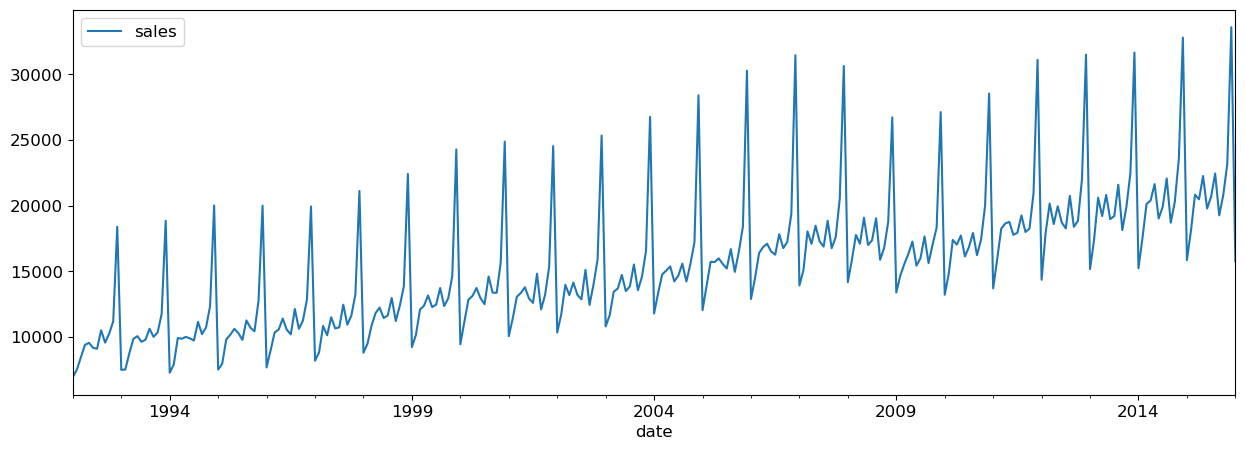

In [75]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

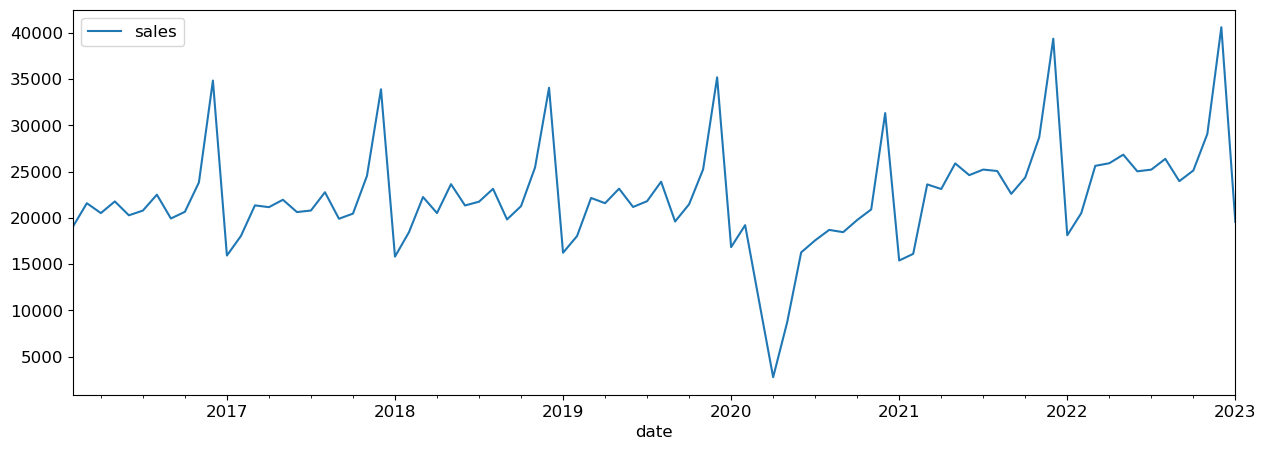

In [76]:
retail_df_test.plot(x="date", y="sales", figsize=(15, 5));

<br><br><br><br>
## Seasonality vs. Trend (Optional)

- Trend: Long-term increase or decrease in the data. The trend can be any function, such as linear or exponential, and can change direction over time.
- Seasonality: **Repeating cycle** in the series with **fixed frequencies** (hour of the day, week, month, year, etc.)
- Cyclicity: Occurs when the data rise and fall, but they are **not of a fixed frequency**
- Noise: The random variation in the series.

We don't like **trend** in the data and try to get rid of it.

Q: Brainstorm on a solution to remove the trend from the above data, or from the stock market data?

A: ???

<br><br><br><br><br>

We can create a dataset using purely lag features.

In [77]:
def lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

Let's create lag features for the full dataframe. 

In [78]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])

In [79]:
retail_train_5 = retail_lag_5.query("date <= 20160101")
retail_test_5 = retail_lag_5.query("date >  20160101")
retail_train_5

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN
...,...,...,...,...,...,...,...
284,2015-09-01,19266,22452.0,20694.0,19781.0,22260.0,20485.0
285,2015-10-01,20794,19266.0,22452.0,20694.0,19781.0,22260.0
286,2015-11-01,23175,20794.0,19266.0,22452.0,20694.0,19781.0
287,2015-12-01,33590,23175.0,20794.0,19266.0,22452.0,20694.0


- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. 
  - **I will just drop the first 5 rows because I have enough data**

In [80]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

,sales,sales-1,sales-2,sales-3,sales-4,sales-5
5,9182,9558.0,9401.0,8475.0,7524.0,6938.0
6,9103,9182.0,9558.0,9401.0,8475.0,7524.0
7,10513,9103.0,9182.0,9558.0,9401.0,8475.0
8,9573,10513.0,9103.0,9182.0,9558.0,9401.0
9,10254,9573.0,10513.0,9103.0,9182.0,9558.0
...,...,...,...,...,...,...
284,19266,22452.0,20694.0,19781.0,22260.0,20485.0
285,20794,19266.0,22452.0,20694.0,19781.0,22260.0
286,23175,20794.0,19266.0,22452.0,20694.0,19781.0
287,33590,23175.0,20794.0,19266.0,22452.0,20694.0


In [81]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [82]:
retail_model = RandomForestRegressor(random_state=42)
retail_model.fit(retail_train_5_X, retail_train_5_y);
print("Train-set R^2: {:.2f}".format(retail_model.score(retail_train_5_X, retail_train_5_y)))

Train-set R^2: 0.96


Given this, we can now predict the sales

In [83]:
from sklearn.metrics import r2_score
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
print("Test-set R^2: {:.2f}".format(r2_score(retail_test_5["sales"], preds)))

Test-set R^2: -0.17


The results are bad; meaning either of the following:
 - the past 5 months of sales **is not a good indicator of the next month's sale**  
 OR
 - the **model** (RandomForestRegressor) is not a good fit for this problem  
 OR
 - the data was not well engineered --> this one probably is the reason here

**However, for now, let's ignore the fact that the results are bad :) We are using this dataset to teach some new concepts ;-)**

In [84]:
retail_test_5_preds = retail_test_5.assign(predicted_sales=preds)
retail_test_5_preds.tail()

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,predicted_sales
368,2022-09-01,23966,26376.0,25214.0,25031.0,26831.0,25904.0,17205.11
369,2022-10-01,25120,23966.0,26376.0,25214.0,25031.0,26831.0,29829.02
370,2022-11-01,29072,25120.0,23966.0,26376.0,25214.0,25031.0,25176.00
371,2022-12-01,40615,29072.0,25120.0,23966.0,26376.0,25214.0,15923.46
372,2023-01-01,19550,40615.0,29072.0,25120.0,23966.0,26376.0,16358.48


Question for you:
- What would have been a good **Baseline** for this problem?

A: ???

## Predict Multiple Steps Into the Future

What if we want to predict multiple future steps
- e.g. rain for the day after tomorrow in the Rain Prediction problem
- e.g. sales of the month after next month (or 5 months into the future) in the sale prediction problem

**There are a few approaches which could be employed:**
1. Train a separate model for each number of months.  
  E.g. one model that predicts sales for next month, another model that predicts sales in two months, etc.
  
2. Use a multi-output model that jointly predicts RainTomorrow, RainIn2Days, etc.   
  (we have not covered, and won't cover, models with multiple outputs in CPSC330)
3. Use one model and **sequentially (recursively) predict** using a `for` loop.   
  This requires predicting _all_ features that the model needs   
  This is doable in the example above where our only feature is the **number of sales**
  
  <img src="https://www.cienciadedatos.net/images/diagram-recursive-mutistep-forecasting.png" width="900">
  
  <img src="https://www.cienciadedatos.net/images/forecasting_multi-step_en.gif">     
  
  
   [img source](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

If we decide to use approach 3, we would predict these values and then pretend they are true! For example, given that it's November 2022

1. Predict December 2022 sales
2. Then, to predict for January 2023, we need to know December 2022 sales. Use our _prediction_ for December 2022 as the truth.
3. Then, to predict for February 2023, we need to know December 2022 and January 2023 sales. Use our predictions.
4. Etc etc.

<br><br>

## Trends 

- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

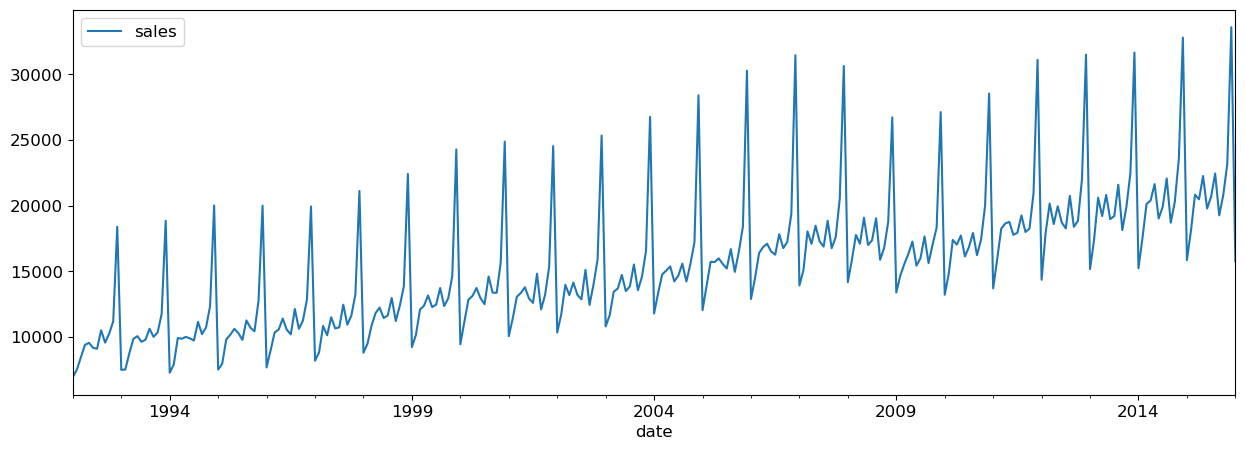

In [85]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

- It looks like there's a **trend** here - the sales are going up over time. 

Let's say we encoded the date as a feature in days like this:

In [86]:
retail_train_5_date = retail_lag_5.query("date <= 20160101")
first_day_retail = retail_train_5_date["date"].min()

retail_train_5_date = retail_train_5_date.assign(
    Days_since=retail_train_5_date["date"].apply(lambda x: (x - first_day_retail).days)
)
retail_train_5_date.head(10)

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,Days_since
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN,0
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN,31
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN,60
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN,91
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN,121
5,1992-06-01,9182,9558.0,9401.0,8475.0,7524.0,6938.0,152
6,1992-07-01,9103,9182.0,9558.0,9401.0,8475.0,7524.0,182
7,1992-08-01,10513,9103.0,9182.0,9558.0,9401.0,8475.0,213
8,1992-09-01,9573,10513.0,9103.0,9182.0,9558.0,9401.0,244
9,1992-10-01,10254,9573.0,10513.0,9103.0,9182.0,9558.0,274


- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - **Thus tree-based models cannot model trends.**
  - **This is really important to know!!**
- Often, **we capture the trend separately** and use a dataset **without trend**

<br><br><br><br>

## A more complicated dataset

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [87]:
rain_df = pd.read_csv("../data/weatherAUS.csv")
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [88]:
rain_df.shape

(145460, 23)

#### Goals

- Can the date/time features help us predict the target value?
- Can we **forecast** into the future? Can we predict whether it's going to rain tomorrow? 
- The target variable is `RainTomorrow`. The target is categorical and not continuous in this case. 

In [89]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [90]:
rain_df.describe(include="all")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


- A number of missing values. 
- Some target values are also missing. 
- **Dropping these rows** 

In [91]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

#### Parsing datetimes 

- In general, datetimes are a huge pain! 
    - Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [92]:
dates_rain = pd.to_datetime(rain_df["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

They are all the same format, so we can also compare dates:

In [93]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

In [94]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

In [95]:
(dates_rain[1] - dates_rain[0]).days

1

We can also easily extract information from the date columns. 

In [96]:
dates_rain[1]

Timestamp('2008-12-02 00:00:00')

In [97]:
dates_rain[1].month_name()

'December'

In [98]:
dates_rain[1].day_name()

'Tuesday'

In [99]:
dates_rain[1].is_year_end

False

In [100]:
dates_rain[1].is_leap_year

True

Above pandas identified the date column automatically. You can tell pandas to parse the dates when reading in the CSV:

In [101]:
rain_df = pd.read_csv("../data/weatherAUS.csv", parse_dates=["Date"])
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Train/test splits 

- Remember that we should not be calling the usual `train_test_split` with shuffling because 
- If we want to forecast, we aren't allowed to know what happened in the future!

In [102]:
rain_df["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [103]:
rain_df["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [104]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [105]:
len(train_df)

109887

In [106]:
len(test_df)

35573

In [107]:
len(test_df) / (len(train_df) + len(test_df))

0.24455520417984325

As we can see, we're still using about 25% of our data as test data.

Here is the data for **Sydney**

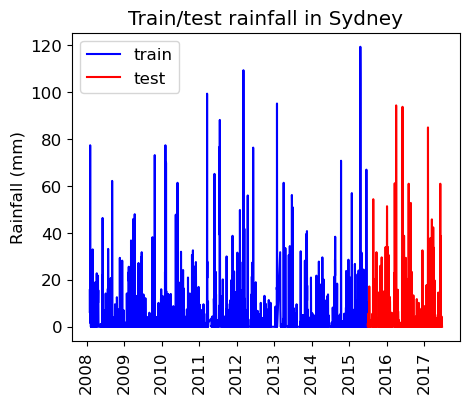

In [108]:
train_df_sort = train_df.query("Location == 'Sydney'").sort_values(by="Date")
test_df_sort = test_df.query("Location == 'Sydney'").sort_values(by="Date")

plt.figure(figsize=(5,4))
plt.plot(train_df_sort["Date"], train_df_sort["Rainfall"], "b", label="train")
plt.plot(test_df_sort["Date"], test_df_sort["Rainfall"], "r", label="test")
plt.xticks(rotation="vertical")
plt.legend()
plt.ylabel("Rainfall (mm)")
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

Let's define a preprocessor with a column transformer. 

In [109]:
train_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109887 entries, 0 to 144733
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           109887 non-null  datetime64[ns]
 1   Location       109887 non-null  object        
 2   MinTemp        108951 non-null  float64       
 3   MaxTemp        109155 non-null  float64       
 4   Rainfall       107501 non-null  float64       
 5   Evaporation    67092 non-null   float64       
 6   Sunshine       63224 non-null   float64       
 7   WindGustDir    101699 non-null  object        
 8   WindGustSpeed  101744 non-null  float64       
 9   WindDir9am     101425 non-null  object        
 10  WindDir3pm     107325 non-null  object        
 11  WindSpeed9am   108345 non-null  float64       
 12  WindSpeed3pm   108346 non-null  float64       
 13  Humidity9am    107990 non-null  float64       
 14  Humidity3pm    108065 non-null  float64       
 15  

- We have missing data. 
- We have categorical features and numeric features. 

- Let's define feature types. 
- Let's start with dropping the date column and treating it as a usual supervised machine learning problem. 

In [111]:
numeric_features = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
]
categorical_features = [
    "Location",
    "WindGustDir",
    "WindDir9am",
    "WindDir3pm",
    "RainToday",
]
drop_features = ["Date"]
target = ["RainTomorrow"]

In [114]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["RainTomorrow"]
    y_test = test_df["RainTomorrow"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [115]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [116]:
X_train_enc.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_missing,RainToday_No,RainToday_Yes,RainToday_missing
0,0.205946,-0.024281,-0.204073,-0.139004,0.162171,0.296641,0.662651,0.598878,0.113272,-1.439598,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.742726,0.290500,-0.274024,-0.139004,0.162171,0.296641,-1.128289,0.372058,-1.321722,-1.293752,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.126890,0.376350,-0.274024,-0.139004,0.162171,0.448400,0.550717,0.825697,-1.640610,-1.050676,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.458124,0.705440,-0.274024,-0.139004,0.162171,-1.220950,-0.344753,-1.102269,-1.268574,-1.731290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.854205,1.320695,-0.157439,-0.139004,0.162171,0.069003,-0.792488,0.145239,0.697899,-0.904830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### `DummyClassifier`

In [117]:
dc = DummyClassifier()
dc.fit(X_train_enc, y_train == "Yes");

In [118]:
dc.score(train_df, y_train == "Yes")

0.7799375722332942

In [119]:
y_train.value_counts()

No     83320
Yes    24182
Name: RainTomorrow, dtype: int64

In [120]:
dc.score(X_test_enc, y_test == 'Yes')

0.7836842549124335

### LogisticRegression

The function below trains a logistic regression model on the train set, reports train and test scores, and returns learned coefficients as a dataframe. 

In [121]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["logisticregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [122]:
score_lr_print_coeff(preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.195278
Pressure9am,0.839256
WindGustSpeed,0.687754
Location_Witchcliffe,0.675642
Location_Perth,0.612783
...,...
Location_Wollongong,-0.711564
Location_Townsville,-0.713796
Location_Katherine,-0.715617
Location_MountGinini,-0.880189


### Cross-validation

- We can carry out cross-validation using [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split). 
- However, things are actually more complicated here because this dataset has **multiple time series**, 
  - one per location. 

In [123]:
train_df.sort_values(by=["Date", "Location"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


We have to evaluate each city separately; **for now, we will only focus on Sydney**

(you should repeat the same process for all cities and report their average)

In [124]:
train_df_sidney = train_df[train_df.Location == "Sydney"].sort_values(by=["Date"])
y_train_sidney = train_df_sidney["RainTomorrow"]

In [125]:
train_df_sidney

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32789,2015-06-26,Sydney,10.1,19.2,6.2,2.0,7.2,W,26.0,WNW,...,85.0,40.0,1032.9,1031.1,1.0,3.0,11.7,18.7,Yes,No
32790,2015-06-27,Sydney,8.3,19.4,0.0,1.8,9.7,W,26.0,WNW,...,87.0,44.0,1032.6,1029.2,0.0,1.0,9.7,19.0,No,No
32791,2015-06-28,Sydney,7.4,19.6,0.0,2.6,9.5,W,28.0,W,...,73.0,53.0,1032.9,1030.9,0.0,1.0,9.3,18.5,No,No
32792,2015-06-29,Sydney,9.3,19.5,0.0,1.0,5.1,W,22.0,W,...,84.0,54.0,1033.4,1030.0,7.0,6.0,11.0,17.8,No,No


In [126]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cross_val_score(lr_pipe, train_df_sidney, y_train_sidney, cv=TimeSeriesSplit()).mean()

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 108, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users

nan

### Encoding date/time as feature(s)

- Use the `Date` to help us predict the target (Feature Engineering)
  - e.g. different amounts of rain in different seasons.
  

### Encoding time as an number

**Idea 1 (bad and not-recommended idea)**: Create an ever-increasing column of "days since Nov 1, 2007".

**Q: Why is it a bad idea?**

Answer: ????

In [127]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [128]:
first_day = train_df["Date"].min()

train_df = train_df.assign(
    Days_since_2007=train_df["Date"].apply(lambda x: (x - first_day).days)
)
test_df = test_df.assign(
    Days_since_2007=test_df["Date"].apply(lambda x: (x - first_day).days)
)

In [129]:
train_df.sort_values(by="Date").head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Days_since_2007
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,0
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,1
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,3
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,4
45592,2007-11-06,Canberra,6.2,16.9,0.0,5.8,8.2,SE,44.0,SE,...,57.0,1023.8,1021.7,7.0,5.0,10.9,14.8,No,No,5
45593,2007-11-07,Canberra,6.1,18.2,0.2,4.2,8.4,SE,43.0,SE,...,47.0,1024.6,1022.2,4.0,6.0,12.4,17.3,No,No,6
45594,2007-11-08,Canberra,8.3,17.0,0.0,5.6,4.6,E,41.0,SE,...,57.0,1026.2,1024.2,6.0,7.0,12.1,15.5,No,No,7
45595,2007-11-09,Canberra,8.8,19.5,0.0,4.0,4.1,S,48.0,E,...,48.0,1026.1,1022.7,7.0,7.0,14.1,18.9,No,Yes,8
45596,2007-11-10,Canberra,8.4,22.8,16.2,5.4,7.7,E,31.0,S,...,32.0,1024.1,1020.7,7.0,1.0,13.3,21.7,Yes,No,9


In [130]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since_2007"],
    categorical_features,
    drop_features,
    target
)

In [131]:
score_lr_print_coeff(preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.195236
Pressure9am,0.839744
WindGustSpeed,0.687852
Location_Witchcliffe,0.676669
Location_Perth,0.613399
...,...
Location_Wollongong,-0.710839
Location_Katherine,-0.711651
Location_Townsville,-0.712856
Location_MountGinini,-0.878899


**Idea 2 (better idea): Capture year as a new feature**

Because: there is correlation between amount of rain in a year in different regions and in the same region

In [ ]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

train_df = train_df.assign(
    year=train_df["Date"].dt.year
)
test_df = test_df.assign(
    year=test_df["Date"].dt.year
)

In [ ]:
train_df.sort_values(by="Date").head(10)

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["year"],
    categorical_features,
    drop_features,
    target
)

In [ ]:
score_lr_print_coeff(preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc)

- Can you think of other ways to generate features from the `Date` column? 
  - What about the month?
    - How should we encode month? Categorical variable? Ordinal? Else?

------------
**[Study on your own]**

### One-hot encoding of the month

In [ ]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

train_df = train_df.assign(
    year=train_df["Date"].dt.year
)
test_df = test_df.assign(
    year=test_df["Date"].dt.year
)

In [ ]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

In [ ]:
train_df[["Date", "Month"]].sort_values(by="Month")

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month", "year"], 
    drop_features,
    target
)

In [ ]:
score_lr_print_coeff(preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc)

No change in the results. 

### One-hot encoding seasons

How about just summer/winter as a feature?

In [ ]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [ ]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

In [ ]:
train_df

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Season", "year"],
    drop_features + ["Month"],
    target
)

In [ ]:
X_train_enc.columns

In [ ]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc
)

In [ ]:
coeff_df.loc[["Season_Fall", "Season_Summer", "Season_Winter", "Season_Autumn"]]

- No improvements in the scores but the **coefficients make some sense**
  - A negative coefficient for summer and a positive coefficients for winter. 

In [ ]:
train_df.plot(x="Date", y="Rainfall")
plt.ylabel("Rainfall (mm)");


**[end of Study on your own]**

------------

<br><br><br><br><br><br>

## Lag-based Features

In [ ]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [ ]:
train_df.head()


Two important points:
- **Make sure your dataset is properly sorted.**
- If you are looking at the data as a TimeSeries, make sure the "events" all belong to the same entity

In [ ]:
train_df.sort_values(by=["Location", "Date"], inplace=True)

We can "lag" (or "shift") a time series in Pandas with the .shift() method. 

In [ ]:
train_df = train_df.assign(Rainfall_lag1=train_df["Rainfall"].shift(1))

In [ ]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][:10]

- But we have multiple time series here and we need to be more careful with this. 
- When we switch from one location to another we do not want to take the value from the previous location. 

In [ ]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code

    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby(
        "Location"
    ):  # Each location is its own time series
        new_df.loc[df_location.index[lag:], new_feature_name] = df_location.iloc[:-lag][
            orig_feature
        ].values
    return new_df

In [ ]:
train_df = create_lag_feature(train_df, "Rainfall", 1)

In [ ]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2460:2480]

Now it looks good! 

In [ ]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [ ]:
rain_df_modified

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Rainfall_lag1"],
    categorical_features,
    drop_features,
    target
)

In [ ]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc
)

In [ ]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

- Rainfall from today has a positive coefficient. 
- Rainfall from yesterday has a positive but a smaller coefficient. 
- If we didn't have rainfall from today feature, rainfall from yesterday feature would have received a bigger coefficient.

- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! 
  - **`RainToday` is the lagged version of the target `RainTomorrow`**
- We could also create lagged version of other features, or more lags

In [ ]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 2)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 3)
rain_df_modified = create_lag_feature(rain_df_modified, "Humidity3pm", 1)

In [ ]:
rain_df_modified[
    [
        "Date",
        "Location",
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
].head(10)

Note the pattern of `NaN` values. 

In [ ]:
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features
    + ["Rainfall_lag1", "Rainfall_lag2", "Rainfall_lag3", "Humidity3pm_lag1"],
    categorical_features,
    drop_features,
    target
)

In [ ]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train == "Yes", test_df, y_test == "Yes", X_train_enc
)

In [ ]:
lr_coef.loc[
    [
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
]

Note the pattern in the magnitude of the coefficients. 

<br><br><br><br>



## What we did NOT cover?


### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We took different route in this course, and stick to our supervised learning tools.

It's good to learn what it means to have a **stationary signal**

### Deep learning 

- Recently, deep learning has been very successful.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - [This is a good](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) blog post about **LSTMs**.
- Transformers are kind of replacing Recurrent approaches such as LSTM
- 1D CNNs (see last lecture) are also used for time series.

### Types of problems involving time series

- A single label associated with an entire time series. 
  - e.g., in fraud detection, 
    - labelling each transaction as fraud/normal   
    vs.
    - labelling a person as bad/good based on their entire history.
- Inference problems
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
  - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month.
  - Some of our approaches would not make sense, like the lags.

If the "time of events" is itself a variable that you want to predict, we get into the realm of **Event Sequence Forecasting** which is not the same as **Time Series Forecasting**

### Other software package

- A good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).
- sktime
    - Time series classification
    - forecasting
- tslearn 
    - classification
    - regression
    - clustering

### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.


<br><br><br><br><br>
**Final Note to Remember**: 
- The lagged features could contains 10s or 100s of the latest historical events as a feature (don't need to be limited to 1 or 5 latest events).
- You can engineer the features to **assign more weight to recent** events than **older events** or you can trust your model to learn such pattern based on the data